!["Movies"](Images\title.png)

# Flixnet Recommendation System

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV


## Business Problem

Flixnet is a large movie streaming platform that draws in many users every day. We are tasked with creating an app that recommends movies based on user ratings for the 20 most rated films on the platform. Based on the rating of these 20 films, we use ML to test and build the best model that provides the top 5 movie recommendations. 

## Data Exploration

In [16]:
links_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [17]:
links_df.head()
movies_df.head()
ratings_df.head()
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [18]:
links_df.info()
movies_df.info()
ratings_df.info()
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  fl

We are most intested in ratings_df as it contains all the relevant columns.

In [19]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [20]:
print("userIds", ratings_df['userId'].nunique())
print("movieIds", ratings_df['movieId'].nunique())

userIds 610
movieIds 9724


We have 610 unique users and 9724 different movies

In [21]:
ratings_df['timestamp']

0          964982703
1          964981247
2          964982224
3          964983815
4          964982931
             ...    
100831    1493848402
100832    1493850091
100833    1494273047
100834    1493846352
100835    1493846415
Name: timestamp, Length: 100836, dtype: int64

### Dealing with SuperUsers:



In [22]:
ratings_df['userId'].value_counts()

sp = ratings_df['userId'].value_counts()
sp

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: count, Length: 610, dtype: int64

Superusers are users who have reviewed more than 500 films. We choose this cut off based off of this histogram:

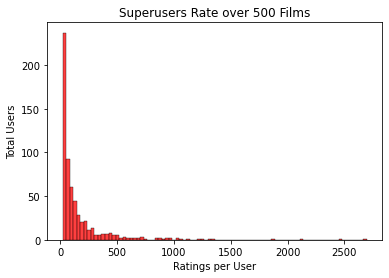

In [23]:
ax = sns.histplot(ratings_df["userId"].value_counts(), color="red", )
plt.xlabel('Ratings per User')
plt.ylabel('Total Users')
plt.title('Superusers Rate over 500 Films')
plt.show();

In [24]:
#this removes superusers from ratings_df
ratings_df_nosuper = ratings_df[ratings_df.groupby('userId')['userId'].transform('size') < 500]

In [25]:
ratings_df_nosuper['userId'].value_counts()

userId
57     476
381    474
368    469
509    467
469    465
      ... 
576     20
431     20
257     20
442     20
278     20
Name: count, Length: 566, dtype: int64

we now have ratings_df without superusers

## Data Processing for Modeling

We will be looking and modeling ratings_df, as it contains all the columns we are interested in.

In [26]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [27]:
ratings_df_nosuper

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
99529,609,892,3.0,847221080
99530,609,1056,3.0,847221080
99531,609,1059,3.0,847221054
99532,609,1150,4.0,847221054


In [28]:
#remove timestamp column, which is unnecessary for modeling
ratings_df = ratings_df.drop("timestamp", axis=1)
ratings_df

ratings_df_nosuper = ratings_df_nosuper.drop('timestamp', axis=1)
ratings_df_nosuper

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
99529,609,892,3.0
99530,609,1056,3.0
99531,609,1059,3.0
99532,609,1150,4.0


In [29]:
ratings_df_nosuper["userId"].nunique()

566

Transform dataset into suprise compatible data

In [30]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

In [31]:
full_dataset = data.build_full_trainset()

#view the number of users and items
print('Number of users: ', full_dataset.n_users, '\n')
print('Number of items: ', full_dataset.n_items)

Number of users:  610 

Number of items:  9724


Splitting Data into Data set A, for training, and B for testing:

In [32]:
## We use train_test_split

trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

In [33]:
#function for outputting the accuracy predictions on an algorithm

def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

## Determining the Best Model

Compare different models and determine which is the best. We will use RMSE to evaluate models.

### Baseline: 

Our baseline model will be KNNBasic, a basic collaborative filtering algorithm, with no parameters

In [34]:
baseline_model = KNNBasic()
train_and_test_pred(baseline_model, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


biased accuracy on train set: 
RMSE: 0.7110
0.710986894321433
MAE:  0.5316
0.5316262167615223
unbiased accuracy on test set: 
RMSE: 0.9561
0.9560731582415551
MAE:  0.7325
0.7325203978636554


In [35]:
#Scores for KNN Basic via cross validation
cv_knn_basic = cross_validate(baseline_model, data)
print("mean fit time", np.mean(cv_knn_basic['fit_time']))
print("mean test time", np.mean(cv_knn_basic['test_time']))
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean fit time 0.16662588119506835
mean test time 1.533193016052246
mean test rmse 0.9472924723588475


### SVD:

In [36]:
## Scores for Baseline SVD Crossvalidation

svd = SVD()
cv_svd = cross_validate(svd, data)
print("mean fit time", np.mean(cv_svd['fit_time']))
print("mean test time", np.mean(cv_svd['test_time']))
print("mean test rmse", np.mean(cv_svd['test_rmse']))


mean fit time 4.7715202331542965
mean test time 0.16288437843322753
mean test rmse 0.8728899483378709


In [37]:
train_and_test_pred(svd, trainset, testset)

biased accuracy on train set: 
RMSE: 0.6377
0.6377496396862512
MAE:  0.4949
0.49494925639166554
unbiased accuracy on test set: 
RMSE: 0.8833
0.8833132735525406
MAE:  0.6797
0.6796868386563981


In [38]:
# performing a gridsearch with SVD

params = {
    'n_factors': [100,150,200],
    'n_epochs': [20,80,100],
    'lr_all': [0.008,0.01],
    'reg_all': [0.07,0.1]
}

SVD_grid = GridSearchCV(SVD, param_grid = params, cv=5)
SVD_grid.fit(data)

KeyboardInterrupt: 

In [ ]:
#view grid search results
print(SVD_grid.best_params)
print(SVD_grid.best_score)

{'rmse': {'n_factors': 200, 'n_epochs': 80, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}}
{'rmse': 0.8560735098716264, 'mae': 0.6560731046872148}


In [ ]:
## choose the best algo
svd_best_algo = SVD_grid.best_estimator['rmse']

In [ ]:
# Use our function to output train/test predictions
train_and_test_pred(svd_best_algo, trainset, testset)

biased accuracy on train set: 
RMSE: 0.4883
0.4882596225926168
MAE:  0.3735
0.3735412240033904
unbiased accuracy on test set: 
RMSE: 0.8543
0.8543282687876524
MAE:  0.6539
0.6538737266430302


In [ ]:
#Scores for Best SVD via cross validation
cv_best_svd = cross_validate(svd_best_algo, data)
print("mean fit time", np.mean(cv_best_svd['fit_time']))
print("mean test time", np.mean(cv_best_svd['test_time']))
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))

mean fit time 21.290761184692382
mean test time 0.16873936653137206
mean test rmse 0.8573543735834015


### KNNBasic:

In [ ]:
## Scores for Baseline KNNBasic Crossvalidation

knn_basic = KNNBasic(sim_options={"name": 'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
print("mean fit time", np.mean(cv_knn_basic['fit_time']))
print("mean test time", np.mean(cv_knn_basic['test_time']))
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

mean fit time 0.8891281127929688
mean test time 1.5582314491271974
mean test rmse 0.9827044028055305


In [ ]:
train_and_test_pred(knn_basic, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.6545
0.6545231101040803
MAE:  0.4875
0.4875351046715471
unbiased accuracy on test set: 
RMSE: 0.9876
0.9875557821282731
MAE:  0.7593
0.7592809692388454


In [ ]:
## GridSearch with KNNBasic
## note: this takes several minutes to run
params = {
    'k': [20,40,60],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
        'user_based': [True,False]   
    }
}
KNNBasic_grid = GridSearchCV(KNNBasic, param_grid = params, cv=5)
KNNBasic_grid.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [ ]:
#view grid search results
print(KNNBasic_grid.best_params)
print(KNNBasic_grid.best_score)

{'rmse': {'k': 60, 'sim_options': {'name': 'msd', 'user_based': False}}, 'mae': {'k': 60, 'sim_options': {'name': 'msd', 'user_based': False}}}
{'rmse': 0.9110794614999813, 'mae': 0.7013363323211289}


In [ ]:
#take the best model and 
#test on train/test 
KNNbasic_best_algo = KNNBasic_grid.best_estimator['rmse']
train_and_test_pred(KNNbasic_best_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.5014
0.5013979150537194
MSE: 0.2514
0.2513998692202169
unbiased accuracy on test set: 
RMSE: 0.9168
0.9167722493305924
MSE: 0.8405
0.8404713571426738


In [ ]:
#Scores for Best KNNbasic via cross validation
cv_best_knnbasic = cross_validate(KNNbasic_best_algo, data)
print("mean fit time", np.mean(cv_best_knnbasic['fit_time']))
print("mean test time", np.mean(cv_best_knnbasic['test_time']))
print("mean test rmse", np.mean(cv_best_knnbasic['test_rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean fit time 3.0111228942871096
mean test time 5.7388105392456055
mean test rmse 0.9114785181698979


### KNNBaseline

In [ ]:
##view our cross validation score with KNNBaseline:
knn_baseline = KNNBaseline(sim_options={"name": 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data)
print("mean fit time", np.mean(cv_knn_baseline['fit_time']))
print("mean test time", np.mean(cv_knn_baseline['test_time']))
print("mean test rmse", np.mean(cv_knn_baseline['test_rmse']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
mean fit time 0.7264693260192872
mean test time 1.4220123767852784
mean test rmse 0.8885902010859313


In [ ]:
## now view our accuracy with train/test data
train_and_test_pred(knn_baseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.5759
0.5759278845918823
unbiased accuracy on test set: 
RMSE: 0.8928
0.8927787505891083


In [ ]:
## GridSearch with KNNBaseline
## note: this takes several minutes to run
params = {
    'k': [10,20,40,50],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
    },
    'bsl_options': {
        "method": ["als","sgd"],
        'reg': [0.02,0.5, 1, 2],
        'n_epochs': [20,40]
    }
}
KNNBaseline_grid = GridSearchCV(KNNBaseline, param_grid = params, cv=5)
KNNBaseline_grid.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson simila

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity ma

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

In [ ]:
#view grid search results
print(KNNBaseline_grid.best_params)
print(KNNBaseline_grid.best_score)

{'rmse': {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}, 'bsl_options': {'method': 'sgd', 'reg': 0.02, 'n_epochs': 40}}, 'mae': {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}, 'bsl_options': {'method': 'sgd', 'reg': 0.02, 'n_epochs': 40}}}
{'rmse': 0.8802652852912548, 'mae': 0.6735251878359343}


In [ ]:
#take the best model and 
#test on train/test 
KNNbaseline_best_algo = KNNBaseline_grid.best_estimator['rmse']
train_and_test_pred(KNNbaseline_best_algo, trainset, testset)

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.6674
0.6674354425827241
MAE:  0.4959
0.49588356081505486
unbiased accuracy on test set: 
RMSE: 0.8856
0.8855729659104958
MAE:  0.6770
0.6770217974769848


In [ ]:
#Scores for Best KNN Baseline via cross validation
cv_best_knnbaseline = cross_validate(KNNbaseline_best_algo, data)
print("mean fit time", np.mean(cv_best_knnbaseline['fit_time']))
print("mean test time", np.mean(cv_best_knnbaseline['test_time']))
print("mean test rmse", np.mean(cv_best_knnbaseline['test_rmse']))

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
mean fit time 0.7519989967346191
mean test time 1.49257230758667
mean test rmse 0.8802127816437599


### NMF

In [ ]:
#Baseline NMF cross validation scores
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print("mean fit time", np.mean(cv_nmf['fit_time']))
print("mean test time", np.mean(cv_nmf['test_time']))
print("mean test rmse", np.mean(cv_nmf['test_rmse']))

mean fit time 4.462008857727051
mean test time 0.09215645790100098
mean test rmse 0.9299608225369275


In [ ]:
## GridSearch with NMF
## note: this takes several minutes to run
params = {
    'n_factors': [10,15,20,25,30],
    "n_epochs": [25,50,75,100],
    "biased": [True,False],
    "reg_pu": [0.06,0.1],
    "reg_qi": [0.06,0.1]
}
nmf_grid = GridSearchCV(NMF, param_grid = params, cv=5)
nmf_grid.fit(data)

In [ ]:
#view grid search results
print(nmf_grid.best_params)
print(nmf_grid.best_score)

{'rmse': {'n_factors': 10, 'n_epochs': 50, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}, 'mae': {'n_factors': 10, 'n_epochs': 100, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}}
{'rmse': 0.8720063978514053, 'mae': 0.6700094555975372}


In [ ]:
#take the best model and 
#test on train/test 
nmf_best = nmf_grid.best_estimator['rmse']
train_and_test_pred(nmf_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.7476
0.7475574332895585
MSE: 0.5588
0.5588421160664727
unbiased accuracy on test set: 
RMSE: 0.8777
0.877655006053826
MSE: 0.7703
0.7702783096513413
RMSE: 0.8777


0.877655006053826

In [ ]:
#Scores for Best NMF via cross validation
cv_best_nmf = cross_validate(nmf_best, data)
print("mean fit time", np.mean(cv_best_nmf['fit_time']))
print("mean test time", np.mean(cv_best_nmf['test_time']))
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))


mean fit time 3.674054431915283
mean test time 0.10129356384277344
mean test rmse 0.8721933507620883


In [ ]:
## Best model so far: 
# NMF rmse: 0.8774 {'n_factors': 10, 'n_epochs': 50, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}, 
# NMF'mae': 0.7698 {'n_factors': 10, 'n_epochs': 100, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}}
#SVD: 0.8633 'rmse': {'n_factors': 200, 'n_epochs': 80, 'lr_all': 0.01, 'reg_all': 0.1}, 
#SVD: 0.7453 'mae': {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}}

### Comparing Models:

In [ ]:
models_df = pd.DataFrame()
models_df['modelId'] = ['KNNBasic', "KNNBaseline", "NMF", "SVD"]
models_df['RMSE'] = [0.988, 0.866, 0.878, 0.863]

##runtime for models:
KNNBasic_runtime = np.mean(cv_knn_basic['fit_time'])+np.mean(cv_knn_basic['test_time'])
print("KNNBasic runtime", KNNBasic_runtime)

KNNBaseline_runtime = np.mean(cv_best_knnbaseline['fit_time'])+np.mean(cv_best_knnbaseline['test_time'])
print("KNNBaseline runtime", KNNBaseline_runtime)

nmf_runtime = np.mean(cv_best_nmf['fit_time'])+np.mean(cv_best_nmf['test_time'])
print("NMF runtime", nmf_runtime)

svd_runtime = np.mean(cv_best_svd['fit_time'])+np.mean(cv_best_svd['test_time'])
print("SVD runtime", svd_runtime)

models_df['runTime'] = [KNNBasic_runtime, KNNBaseline_runtime, nmf_runtime, svd_runtime]

models_df

KNNBasic runtime 1.2278901576995849
KNNBaseline runtime 2.244571304321289
NMF runtime 3.7753479957580565
SVD runtime 21.459500551223755


,modelId,RMSE,runTime
0,KNNBasic,0.988,1.227890
1,KNNBaseline,0.866,2.244571
2,NMF,0.878,3.775348
3,SVD,0.863,21.459501


## Making Recommendations

We want to return the actual title of a movie instead of an ID

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Making simple predictions

Taking our best algorithm so far: SVD

In [ ]:
best_algo = SVD(n_factors= 200, n_epochs= 80, lr_all= 0.01, reg_all= 0.1)
best_algo.fit(trainset)

In [ ]:
best_algo.test(testset)
accuracy.rmse(best_algo.test(testset))

RMSE: 0.7890


0.7890198029563478

### Obtaining User Rankings

Creating a function that allows the current user to rate movies in our database. The function will save the ratings of the current user and give recommendations based on their preferences.

The function `movie_rater()` takes as parameters: 

* `movie_df`: DataFrame - a dataframe containing the movie ids, name of movie, and genres
* `num`: int - number of ratings
* `genre`: string - a specific genre from which to draw movies

The function returns:
* rating_list : list - a collection of dictionaries in the format of {'userId': int , 'movieId': int , 'rating': float}

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userId = 1000
    rating_list = []
    
    while num > 0:    
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
            
        print(movie)
        rating = input("Please rate this movie from 1-5, press n if you have not seen :\n")
    
        try: 
            if 1 <= int(rating) <= 5:
                rating_movie = {'userId': userId, "movieId":movie['movieId'].values[0], "rating": rating}
                rating_list.append(rating_movie)
                num -= 1
        except:
            print('Please enter a valid rating from 1-5')
            continue
    return rating_list


In [ ]:
movies_df.loc[movies_df["movieId"]==663]

,movieId,title,genres
553,663,Kids in the Hall: Brain Candy (1996),Comedy


In [ ]:
## Trying out the function:
user_rating = movie_rater(movies_df, 5, "Comedy")
user_rating

      movieId               title          genres
7565    85565  Chalet Girl (2011)  Comedy|Romance
Please rate this movie from 1-5, press n if you have not seen :
4
      movieId                                        title            genres
7779    91671  Alvin and the Chipmunks: Chipwrecked (2011)  Animation|Comedy
Please rate this movie from 1-5, press n if you have not seen :
4
      movieId                                 title                genres
5668    27644  Remember Me (Ricordati di me) (2003)  Comedy|Drama|Romance
Please rate this movie from 1-5, press n if you have not seen :
4
      movieId                 title  genres
5403    25752  Freshman, The (1925)  Comedy
Please rate this movie from 1-5, press n if you have not seen :
4
      movieId                       title  genres
3331     4509  Great Outdoors, The (1988)  Comedy
Please rate this movie from 1-5, press n if you have not seen :
4


[{'userId': 1000, 'movieId': 85565, 'rating': '4'},
 {'userId': 1000, 'movieId': 91671, 'rating': '4'},
 {'userId': 1000, 'movieId': 27644, 'rating': '4'},
 {'userId': 1000, 'movieId': 25752, 'rating': '4'},
 {'userId': 1000, 'movieId': 4509, 'rating': '4'}]

### Making Predictions with the New Ratings

In [ ]:
user_rating

[{'userId': 1000, 'movieId': 274, 'rating': '5'},
 {'userId': 1000, 'movieId': 2518, 'rating': '4'},
 {'userId': 1000, 'movieId': 46967, 'rating': '3'},
 {'userId': 1000, 'movieId': 6596, 'rating': '2'},
 {'userId': 1000, 'movieId': 274, 'rating': '1'}]

In [ ]:
movie_list20 = [ 356,  318,  296,  593, 2571,  260,  480,  110,  589,  527, 2959, 1, 1196, 2858,   50,   47,  780,  150, 1198, 4993]

In [ ]:
sorted(movie_list20)

[1,
 47,
 50,
 110,
 150,
 260,
 296,
 318,
 356,
 480,
 527,
 589,
 593,
 780,
 1196,
 1198,
 2571,
 2858,
 2959,
 4993]

In [ ]:
## add the new ratings to the original ratings DataFrame
user_ratings_df = pd.DataFrame(user_rating)
ratings_df = pd.concat([ratings_df, user_ratings_df], axis=0)
new_data = Dataset.load_from_df(ratings_df, reader)

In [ ]:
# make predictions for the user
# tuples in the format (movie_id, predicted_score)
recc_movies = []
for m_id in ratings_df['movieId'].unique():
    if (m_id in movie_list20): 
        continue
    else:
        prediction = best_algo.predict(1000,m_id)[3]
        recc_movies.append( (m_id, prediction) )

In [ ]:
# order the predictions from highest to lowest rated

ranked_movies = sorted(recc_movies, key=lambda x:x[1], reverse = True)

In [ ]:
ranked_movies

[(858, 4.267089211806522),
 (1221, 4.231819254507933),
 (750, 4.217218497526687),
 (1213, 4.182435668340897),
 (1276, 4.176829968961727),
 (1204, 4.175200920696795),
 (898, 4.171818590045663),
 (1261, 4.159018750933442),
 (2019, 4.150946001583618),
 (933, 4.150397848386026),
 (48516, 4.1439813120552875),
 (4973, 4.137416739307285),
 (2324, 4.137131647789212),
 (1228, 4.135482403014425),
 (56782, 4.126052161274939),
 (1233, 4.125357807216946),
 (1136, 4.118282185335452),
 (1201, 4.117427543141067),
 (1248, 4.1143224173895225),
 (904, 4.113924405538391),
 (1262, 4.1112671614303995),
 (1104, 4.11087450041822),
 (720, 4.109810540203233),
 (7153, 4.104908305159104),
 (1208, 4.104852940914796),
 (1223, 4.10420501778623),
 (1089, 4.100385525384872),
 (1237, 4.088837773855071),
 (3275, 4.087340681020859),
 (741, 4.083898534430317),
 (5618, 4.076072902710011),
 (57669, 4.074990572741354),
 (1199, 4.071680171926911),
 (2329, 4.071180397403214),
 (7361, 4.064950741977946),
 (112552, 4.06127804732

We create a function `recommended_movies()` that takes in the parameters:
* `user_ratings`: list - list of tuples formulated as (user_id, movie_id) (should be in order of best to worst for this individual)
* `movie_title_df`: DataFrame 
* `n`: int - number of recommended movies 

We print out each recommended *n* movies in order from best to worst

In [ ]:
# return the top n recommendations
def recommended_movies(user_ratings,movie_title_df,n):
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title.values[0], '\n')
        n-= 1
        if n == 0:
            break

In [ ]:
recommended_movies(ranked_movies, movies_df, 5)

Recommendation #  1 :  Godfather, The (1972) 

Recommendation #  2 :  Pulp Fiction (1994) 

Recommendation #  3 :  Shawshank Redemption, The (1994) 

Recommendation #  4 :  Godfather: Part II, The (1974) 

Recommendation #  5 :  Fight Club (1999) 



Combining all into one function:

In [ ]:
def rate_and_rec(ratings_df, movies_df,num, genre=None):
        
    user_rating = movie_rater(movies_df, num, genre)
    
    ## add the new ratings to the original ratings DataFrame
    user_ratings_df = pd.DataFrame(user_rating)
    ratings_df = pd.concat([ratings_df, user_ratings_df], axis=0)
    
    new_data = Dataset.load_from_df(ratings_df, reader)
    best_algo = SVD(n_factors= 200, n_epochs= 80, lr_all= 0.01, reg_all= 0.1)
    best_algo.fit(new_data.build_full_trainset())

    # make predictions for the user
    # create a list of tuples in the format (movie_id, predicted_score)
    recc_movies = []
    for m_id in ratings_df['movieId'].unique():
        prediction = best_algo.predict(1000,m_id)[3]
        recc_movies.append( (m_id, prediction) )
    
    # order the predictions from highest to lowest rated
    ranked_movies = sorted(recc_movies, key=lambda x:x[1], reverse = True)
    
    recommended_movies(ranked_movies,movies_df,5)

In [ ]:
rate_and_rec(ratings_df, movies_df, 5, None)

      movieId               title                    genres
2156     2871  Deliverance (1972)  Adventure|Drama|Thriller
Please rate this movie from 1-5, press n if you have not seen :
4
     movieId                title  \
400      459  Getaway, The (1994)   

                                            genres  
400  Action|Adventure|Crime|Drama|Romance|Thriller  
Please rate this movie from 1-5, press n if you have not seen :
5
      movieId                                              title  \
4348     6350  Laputa: Castle in the Sky (Tenkû no shiro Rapy...   

                                                 genres  
4348  Action|Adventure|Animation|Children|Fantasy|Sc...  
Please rate this movie from 1-5, press n if you have not seen :
3
      movieId                             title                 genres
3233     4369  Fast and the Furious, The (2001)  Action|Crime|Thriller
Please rate this movie from 1-5, press n if you have not seen :
1
      movieId                           

Check out the app code [here.](web_app.py)